# SAM8905 Code Generator Demo

This notebook demonstrates the SAM8905 algorithm code generator, which translates
SAM8905 A-RAM microcode to executable Python or C code.

## Features

- **Abstract backend interface**: Supports multiple target languages
- **Python backend**: Generates standalone Python classes
- **C backend**: Generates C structs and functions
- **Persistent D-RAM**: State persists across frame execution
- **Traceable output**: Comments map generated code to original PC addresses

In [9]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from sam8905_codegen import (
    SAM8905CodeGenerator, PythonBackend, CBackend,
    generate_python, generate_c
)
from sam8905_aram_decoder import decode_algorithm
from sam8905_interpreter import SAM8905Interpreter, plot_waveform

## 1. Basic Example: Sinus Oscillator

Let's start with a simple sinus oscillator algorithm from the SAM8905 programmer's guide.

In [10]:
# Sinus oscillator algorithm
# This produces a sine wave at the specified frequency
sinus_alg = [
    0x016F,  # PC00: RM 0, <WA, WPHI, WSP>  - A=PHI, PHI reg=D[0], WF=0x100 (sinus)
    0x08BF,  # PC01: RM 1, <WB>             - B=D[1] (phase increment)
    0x11F7,  # PC02: RM 2, <WXY, WSP>       - X=sin(PHI), Y=AMP, mix updated
    0x02DF,  # PC03: RADD 0, <WM>           - D[0]=A+B (PHI+DPHI)
    0x06FF,  # PC04: RSP                    - NOP (wait for multiplier)
    0x06FE,  # PC05: RSP, <WACC>            - accumulate AMP x sin(PHI)
] + [0x7FFF] * 26  # Fill rest with NOPs

# Show decoded assembly
print(decode_algorithm(sinus_alg, alg_num=0))

=== Algorithm 0 ===

PC00: 016F  RM 0, <WA, WPHI, WSP> ***
PC01: 08BF  RM 1, <WB>
PC02: 11F7  RM 2, <WXY, WSP> ***
PC03: 02DF  RADD 0, <WM>
PC04: 06FF  RSP, <NOP>
PC05: 06FE  RSP, <WACC>
PC06: 7FFF  RSP, <WSP> ***
PC07: 7FFF  RSP, <WSP> ***
PC08: 7FFF  RSP, <WSP> ***
PC09: 7FFF  RSP, <WSP> ***
PC10: 7FFF  RSP, <WSP> ***
PC11: 7FFF  RSP, <WSP> ***
PC12: 7FFF  RSP, <WSP> ***
PC13: 7FFF  RSP, <WSP> ***
PC14: 7FFF  RSP, <WSP> ***
PC15: 7FFF  RSP, <WSP> ***
PC16: 7FFF  RSP, <WSP> ***
PC17: 7FFF  RSP, <WSP> ***
PC18: 7FFF  RSP, <WSP> ***
PC19: 7FFF  RSP, <WSP> ***
PC20: 7FFF  RSP, <WSP> ***
PC21: 7FFF  RSP, <WSP> ***
PC22: 7FFF  RSP, <WSP> ***
PC23: 7FFF  RSP, <WSP> ***
PC24: 7FFF  RSP, <WSP> ***
PC25: 7FFF  RSP, <WSP> ***
PC26: 7FFF  RSP, <WSP> ***
PC27: 7FFF  RSP, <WSP> ***
PC28: 7FFF  RSP, <WSP> ***
PC29: 7FFF  RSP, <WSP> ***
PC30: 7FFF  RSP, <WSP> ***
PC31: 7FFF  RSP, <WSP> ***


## 2. Generate Python Code

In [11]:
# Generate Python code for the algorithm
py_code = generate_python(sinus_alg, class_name="SinusOscillator")

# Show first 80 lines
for i, line in enumerate(py_code.split('\n')[:80]):
    print(f"{i+1:3d}  {line}")

  1  #!/usr/bin/env python3
  2  """
  3  SAM8905 Algorithm Processor - Generated Code
  4  
  5  Class: SinusOscillator
  6  Instructions: 32
  7  D-RAM addresses used: [0, 1, 2]
  8  
  9  Generated by sam8905_codegen.py
 10  """
 11  
 12  import math
 13  from typing import Optional, Callable
 14  
 15  # Constants
 16  MASK19 = 0x7FFFF  # 19-bit mask
 17  MASK12 = 0xFFF    # 12-bit mask
 18  
 19  # Multiplier constants (Q0.11 format)
 20  CONSTANTS = [
 21      0x001, 0x081, 0x101, 0x181, 0x201, 0x281, 0x301, 0x381,
 22      0x401, 0x481, 0x501, 0x581, 0x601, 0x681, 0x701, 0x781
 23  ]
 24  
 25  # Mix attenuation lookup (dB): 000=mute, 001=-36dB, ..., 111=0dB
 26  MIX_ATTEN = [0, 16, 32, 64, 128, 256, 512, 1024]
 27  
 28  
 29  
 30  def sign_extend_12(val: int) -> int:
 31      """Sign-extend 12-bit value to Python int."""
 32      return val | ~0xFFF if val & 0x800 else val
 33  
 34  
 35  def sign_extend_19(val: int) -> int:
 36      """Sign-extend 19-bit value to Python in

In [12]:
# Execute the generated code to define the class
exec(compile(py_code, '<generated>', 'exec'))

# Create processor instance
proc = SinusOscillator()

# Set up D-RAM for 440Hz sine
# D[0] = PHI (phase) - starts at 0
# D[1] = DPHI (phase increment) - for 440Hz at 44.1kHz: 4096 * 440 / 44100 ≈ 41
# D[2] = AMP with mix bits - amplitude in upper bits, mix in lower

phase_inc = int(4096 * 440 / 44100)  # ~41 for 440Hz
amplitude = 0x400  # Half amplitude (Q0.11)
mix_l = 7  # Full volume
mix_r = 7

dram_init = [0] * 16
dram_init[0] = 0  # PHI starts at 0
dram_init[1] = phase_inc << 7  # DPHI in upper bits
dram_init[2] = (amplitude << 7) | (mix_l << 3) | mix_r  # AMP + mix

proc.init_dram(dram_init)

# Generate 1000 samples (~23ms)
samples = []
for _ in range(1000):
    l, r = proc.execute_frame()
    # Accumulators are 24-bit, output upper 16 bits (match interpreter)
    samples.append((l >> 8, r >> 8))

samples = np.array(samples)
print(f"Generated {len(samples)} samples")
print(f"L range: [{samples[:,0].min()}, {samples[:,0].max()}]")
print(f"R range: [{samples[:,1].min()}, {samples[:,1].max()}]")

Generated 1000 samples
L range: [-368, 367]
R range: [-368, 367]


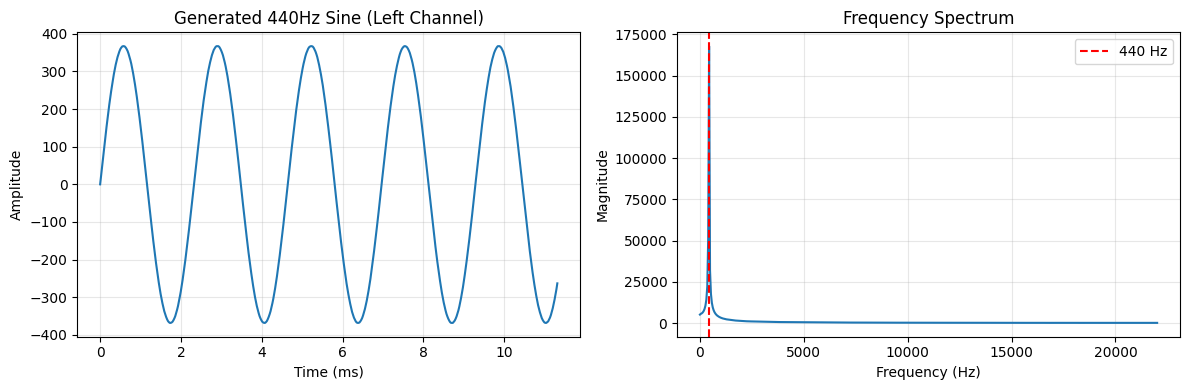

In [6]:
# Plot the generated output
plt.figure(figsize=(12, 4))
time_ms = np.arange(len(samples)) / 44100 * 1000

plt.subplot(1, 2, 1)
plt.plot(time_ms[:500], samples[:500, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Generated 440Hz Sine (Left Channel)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# FFT to verify frequency
fft = np.abs(np.fft.rfft(samples[:, 0]))
freqs = np.fft.rfftfreq(len(samples), 1/44100)
plt.plot(freqs[:500], fft[:500])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
plt.axvline(440, color='r', linestyle='--', label='440 Hz')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Verify Against Interpreter

Compare generated code output with the reference interpreter to ensure correctness.

In [13]:
# Run the same algorithm through the interpreter
interp = SAM8905Interpreter()
interp.load_aram(sinus_alg, offset=0)

# Same D-RAM setup
dram_slot0 = [0] * 16
dram_slot0[0] = 0
dram_slot0[1] = phase_inc << 7
dram_slot0[2] = (amplitude << 7) | (mix_l << 3) | mix_r
dram_slot0[15] = 0x00000  # ALG=0, IDLE=0

interp.load_dram(0, dram_slot0)
interp_samples = interp.run(1000, active_slots=[0])

# Compare
gen_samples = samples  # From earlier

l_diff = np.abs(interp_samples[:, 0] - gen_samples[:, 0])
r_diff = np.abs(interp_samples[:, 1] - gen_samples[:, 1])

print("Comparison: Interpreter vs Generated Code")
print("=" * 45)
print(f"L channel max diff:  {l_diff.max()}")
print(f"R channel max diff:  {r_diff.max()}")
print(f"L channel mean diff: {l_diff.mean():.2f}")
print(f"R channel mean diff: {r_diff.mean():.2f}")

if l_diff.max() == 0 and r_diff.max() == 0:
    print("\n✓ PERFECT MATCH! Generated code is equivalent to interpreter.")
else:
    print("\n✗ Mismatch detected")

Comparison: Interpreter vs Generated Code
L channel max diff:  0
R channel max diff:  0
L channel mean diff: 0.00
R channel mean diff: 0.00

✓ PERFECT MATCH! Generated code is equivalent to interpreter.


## 4. Generate C Code

The same algorithm can be compiled to C for embedded targets.

In [6]:
# Generate C code
c_code = generate_c(sinus_alg, class_name="sinus_osc")

# Show first 100 lines
for i, line in enumerate(c_code.split('\n')[:100]):
    print(f"{i+1:3d}  {line}")

  1  /*
  2   * SAM8905 Algorithm Processor - Generated Code
  3   *
  4   * Struct: sinus_osc_state_t
  5   * Instructions: 32
  6   * D-RAM addresses used: [0, 1, 2]
  7   *
  8   * Generated by sam8905_codegen.py
  9   */
 10  
 11  #ifndef SINUS_OSC_H
 12  #define SINUS_OSC_H
 13  
 14  #include <stdint.h>
 15  #include <stdbool.h>
 16  #include <math.h>
 17  
 18  /* Constants */
 19  #define MASK19 0x7FFFF
 20  #define MASK12 0xFFF
 21  
 22  /* Multiplier constants (Q0.11 format) */
 23  static const int32_t CONSTANTS[16] = {
 24      0x001, 0x081, 0x101, 0x181, 0x201, 0x281, 0x301, 0x381,
 25      0x401, 0x481, 0x501, 0x581, 0x601, 0x681, 0x701, 0x781
 26  };
 27  
 28  /* Mix attenuation lookup */
 29  static const int32_t MIX_ATTEN[8] = {0, 16, 32, 64, 128, 256, 512, 1024};
 30  
 31  /* Callback types */
 32  typedef int32_t (*waveform_read_fn)(uint32_t address);
 33  typedef void (*waveform_write_fn)(uint32_t address, int32_t data, uint32_t phi, int pc);
 34  
 35  
 36  /*

In [7]:
# Save to file for compilation testing
with open('/tmp/sinus_osc.h', 'w') as f:
    f.write(c_code)
print("Saved to /tmp/sinus_osc.h")

# Show file size
print(f"Generated {len(c_code)} bytes of C code")

Saved to /tmp/sinus_osc.h
Generated 7262 bytes of C code


## 5. Complex Example: Reverb Algorithm

Let's try a more complex algorithm - the reverb from Keyfox10.

In [ ]:
# Keyfox10 reverb algorithm (ALG 2)
reverb_alg = [
    0x79F7, 0x207F, 0x28BF, 0x7AFD, 0x082F, 0x7A3F, 0x4ADF, 0x387B,
    0x42DF, 0x7FFF, 0x10F7, 0x48EF, 0x7EFB, 0x487F, 0x7CF7, 0x20FD,
    0x086F, 0x00BE, 0x0ADF, 0x213F, 0x22DB, 0x43DF, 0x10B7, 0x187F,
    0x13DF, 0x307E, 0x40BF, 0x7ABF, 0x207F, 0x22DF, 0x7FFF, 0x7FFF
]

# Show decoded assembly
print(decode_algorithm(reverb_alg, alg_num=2))

In [ ]:
# Generate Python code for reverb
reverb_py = generate_python(reverb_alg, class_name="ReverbProcessor")

print(f"Generated {len(reverb_py)} bytes of Python code")
print(f"\nFirst 50 lines of execute_frame():")
print()

# Find execute_frame and show it
lines = reverb_py.split('\n')
in_execute = False
count = 0
for i, line in enumerate(lines):
    if 'def execute_frame' in line:
        in_execute = True
    if in_execute:
        print(f"{i+1:3d}  {line}")
        count += 1
        if count > 50:
            print("        ...")
            break

## 6. D-RAM Usage Analysis

The code generator analyzes which D-RAM addresses are used for optimization.

In [ ]:
from sam8905_aram_decoder import analyze_dram_usage

# Analyze reverb algorithm
usage = analyze_dram_usage(reverb_alg)

print("D-RAM Usage Analysis for Reverb Algorithm")
print("=" * 45)
print(f"{'Address':>8} {'Reads':>8} {'Writes':>8}")
print("-" * 24)
for addr in sorted(usage.keys()):
    print(f"{addr:>8} {usage[addr]['read']:>8} {usage[addr]['write']:>8}")

print(f"\nTotal addresses used: {len(usage)}")

## 7. Custom Backend Example

You can create custom backends by subclassing `CodeGenBackend`.

In [ ]:
from sam8905_codegen import CodeGenBackend, CodeGenContext, SAM8905CodeGenerator
from sam8905_aram_decoder import decode_instruction, format_instruction

class PseudocodeBackend(CodeGenBackend):
    """Generate readable pseudocode for documentation."""
    
    def emit_header(self, ctx):
        return f"""ALGORITHM: {ctx.class_name}
INSTRUCTIONS: {ctx.instruction_count}
D-RAM USED: {sorted(ctx.dram_usage.keys())}
{'='*50}
"""
    
    def emit_helper_functions(self, ctx):
        return ""
    
    def emit_class_start(self, ctx):
        return "STATE:\n  dram[16]: 19-bit words\n\n"
    
    def emit_class_end(self, ctx):
        return "\nEND ALGORITHM"
    
    def emit_init_method(self, ctx):
        return "INIT: clear dram\n"
    
    def emit_init_dram_method(self, ctx):
        return ""
    
    def emit_execute_frame_start(self, ctx):
        return """EXECUTE_FRAME:
  LOCAL: a, b, x, y, phi, wf, mul_result, l_acc, r_acc
"""
    
    def emit_execute_frame_end(self, ctx):
        return "  RETURN (l_acc, r_acc)\n"
    
    def emit_comment(self, text):
        return f"  ; {text}"
    
    def emit_instruction_comment(self, pc, inst):
        decoded = decode_instruction(inst)
        asm = format_instruction(decoded, show_hex=False)
        return f"\n  ; PC{pc:02d}: {asm}"
    
    def emit_bus_from_dram(self, mad):
        return f"  bus := dram[{mad}]"
    
    def emit_bus_from_adder(self):
        return "  bus := a + b"
    
    def emit_bus_from_multiplier(self):
        return "  bus := mul_result"
    
    def emit_bus_zero(self):
        return "  bus := 0"
    
    def emit_update_carry(self):
        return ""
    
    def emit_write_a(self, wsp, wphi_active):
        if wsp and not wphi_active:
            return "  a := [WSP sampling logic]"
        return "  a := bus"
    
    def emit_write_b(self):
        return "  b := bus"
    
    def emit_write_dram(self, mad, wsp):
        if wsp:
            return f"  IF clear_rqst AND NOT carry: dram[{mad}] := bus"
        return f"  dram[{mad}] := bus"
    
    def emit_write_phi(self, wsp):
        if wsp:
            return "  phi := bus[18:7]; wf := SINUS"
        return "  phi := bus[18:7]"
    
    def emit_write_xy(self, mad, wsp):
        base = "  y := bus[18:7]; x := waveform(wf, phi); mul := x * y"
        if wsp:
            base += "; mix := bus[5:0]"
        return base
    
    def emit_clear_b(self, emitter_sel, wsp, pc):
        if emitter_sel == 3 and wsp:
            return "  b := 0; [WWE: write y to external memory]"
        return "  b := 0"
    
    def emit_write_wf(self):
        return "  wf := bus[17:9]"
    
    def emit_wacc(self):
        return "  l_acc += mul * mix_l; r_acc += mul * mix_r"

# Generate pseudocode
gen = SAM8905CodeGenerator(PseudocodeBackend())
pseudo = gen.generate(sinus_alg, class_name="SinusOscillator")
print(pseudo)

## Summary

The SAM8905 code generator provides:

1. **Python Backend**: Generates executable Python classes for simulation and testing
2. **C Backend**: Generates C code for embedded deployment
3. **Extensible Architecture**: Custom backends can be created by subclassing `CodeGenBackend`
4. **Verified Output**: Generated code matches the reference interpreter exactly
5. **Readable Output**: Comments trace back to original instruction addresses